<a href="https://colab.research.google.com/github/adithi20/-CSE_Projects/blob/main/LSTM_BP_ARTIELSTIFFNESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_excel('/content/LSTM_BP_Data.xlsx')

# Normalize Systolic BP
df['SYSTOLE_NORM'] = df['SYSTOLE'] / 220.0

# Simulate ECG-style signal using impulse train sampling
impulse_interval = 5
df['Impulse'] = 0
df.loc[::impulse_interval, 'Impulse'] = 1
df['Sampled'] = df['SYSTOLE_NORM'] * df['Impulse']
df['Sampled'] = df['Sampled'].fillna(0)


In [2]:
# Simulate arterial stiffness values
np.random.seed(42)  # For reproducibility
df['Arterial_Stiffness'] = np.random.randint(130, 201, size=len(df))
df['Arterial_Stiffness_Norm'] = df['Arterial_Stiffness'] / 200.0  # Normalize


In [3]:
# Define window size for sequences
window_size = 10

X = []
Y = []

for i in range(len(df) - window_size):
    seq_sampled = df['Sampled'].values[i:i+window_size]
    seq_stiffness = df['Arterial_Stiffness_Norm'].values[i:i+window_size]
    seq = np.column_stack((seq_sampled, seq_stiffness))
    X.append(seq)
    Y.append(df['SYSTOLE_NORM'].values[i+window_size])

X = np.array(X)
Y = np.array(Y)


In [4]:
# Split the data
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.125, random_state=42)  # 0.125 x 0.8 = 0.1


In [5]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=16)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.5055 - val_loss: 0.2305
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1556 - val_loss: 0.0226
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0165 - val_loss: 0.0330
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0422 - val_loss: 0.0172
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0187 - val_loss: 0.0075
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - val_loss: 0.0171
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0145 - val_loss: 0.0152
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0096 - val_loss: 0.0079
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 13/20


In [6]:
# Predict on test data
Y_pred = model.predict(X_test).flatten()

# Denormalize the predictions and actual values
Y_pred_actual = Y_pred * 220
Y_test_actual = Y_test * 220

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_actual, Y_pred_actual))
print(f'RMSE: {rmse:.2f} mmHg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
RMSE: 13.63 mmHg


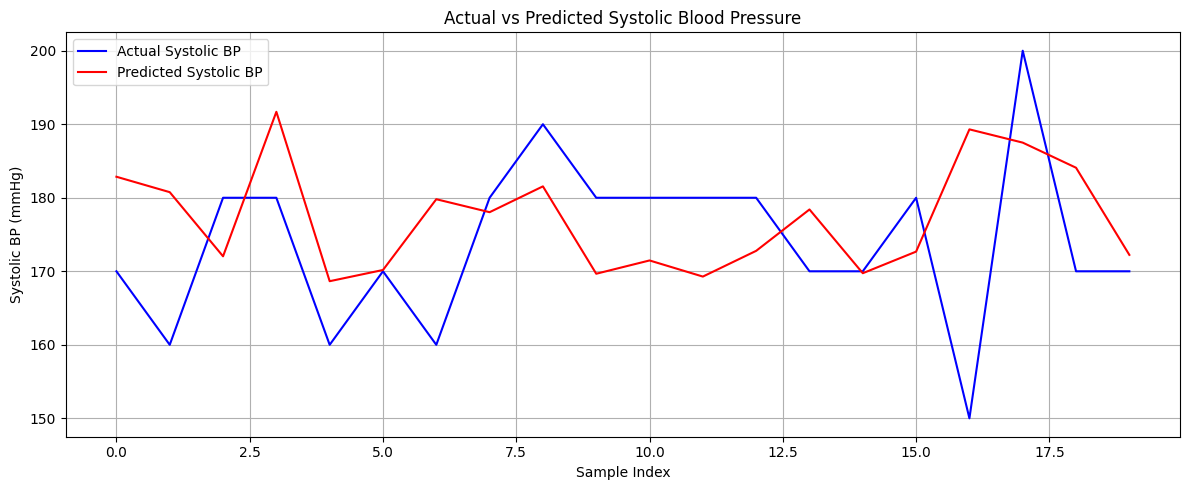

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(Y_test_actual, label='Actual Systolic BP', color='blue')
plt.plot(Y_pred_actual, label='Predicted Systolic BP', color='red')
plt.title('Actual vs Predicted Systolic Blood Pressure')
plt.xlabel('Sample Index')
plt.ylabel('Systolic BP (mmHg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


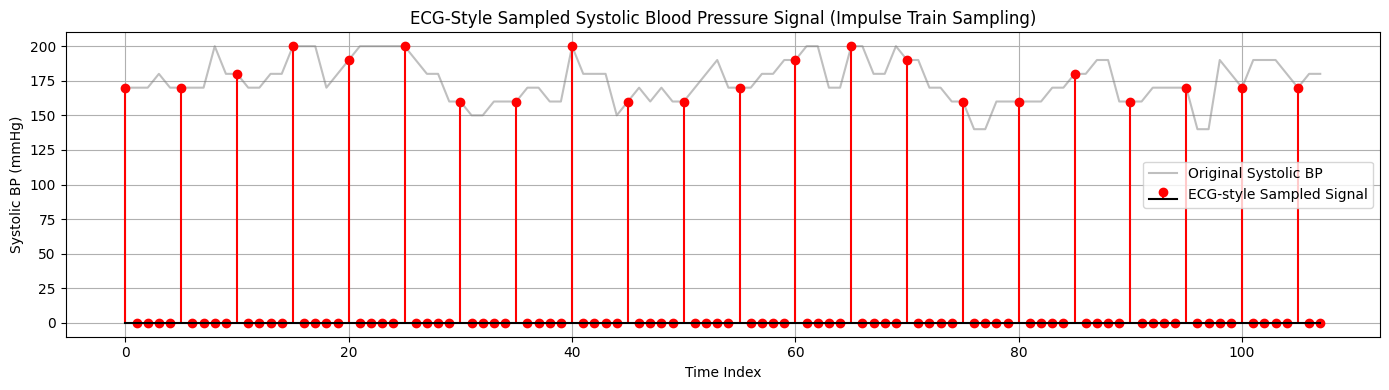

In [8]:
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['SYSTOLE'], label='Original Systolic BP', alpha=0.5, color='gray')
plt.stem(df.index, df['Sampled'] * 220, linefmt='r-', markerfmt='ro', basefmt='k-', label='ECG-style Sampled Signal')
plt.title('ECG-Style Sampled Systolic Blood Pressure Signal (Impulse Train Sampling)')
plt.xlabel('Time Index')
plt.ylabel('Systolic BP (mmHg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Saving LSTM_BP_Data.xlsx to LSTM_BP_Data (8).xlsx
Columns: Index(['DATE', 'SERIAL NUMBER', 'TIME', 'SYSTOLE', 'DIASTOLE'], dtype='object')
✅ Total sequences created: 48 from 12 unique dates
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6953 - val_loss: 0.6900
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.6532 - val_loss: 0.6601
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.6125 - val_loss: 0.6309
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.5734 - val_loss: 0.6024
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.5356 - val_loss: 0.5745
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4991 - val_loss: 0.5471
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.4639 - val_loss: 0.5203
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.4298 - val_loss: 0.4938
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3968 - val_loss: 0.4678
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3648 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


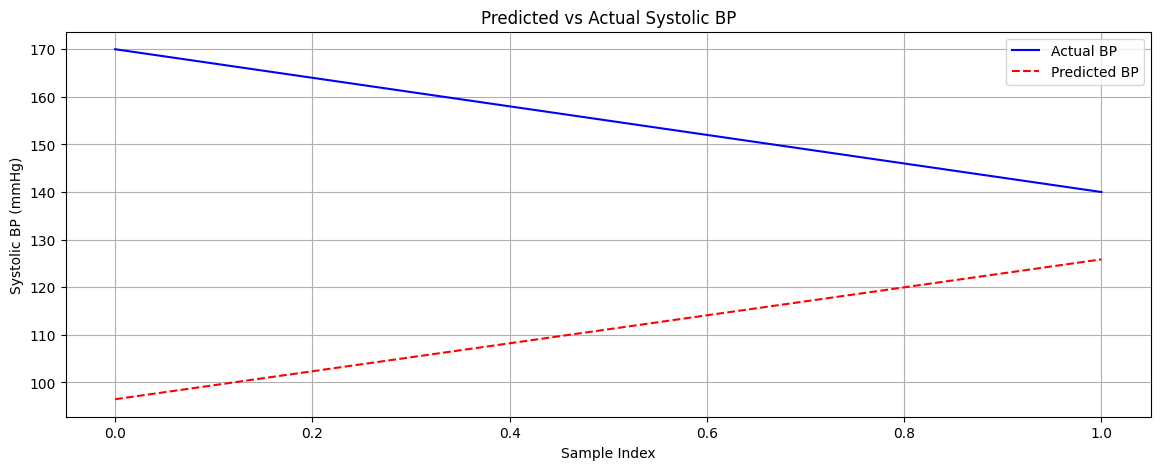

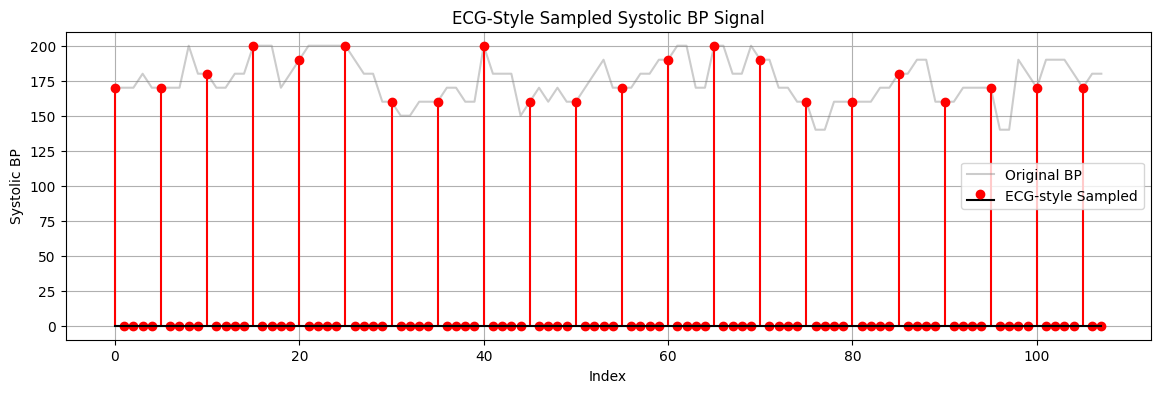

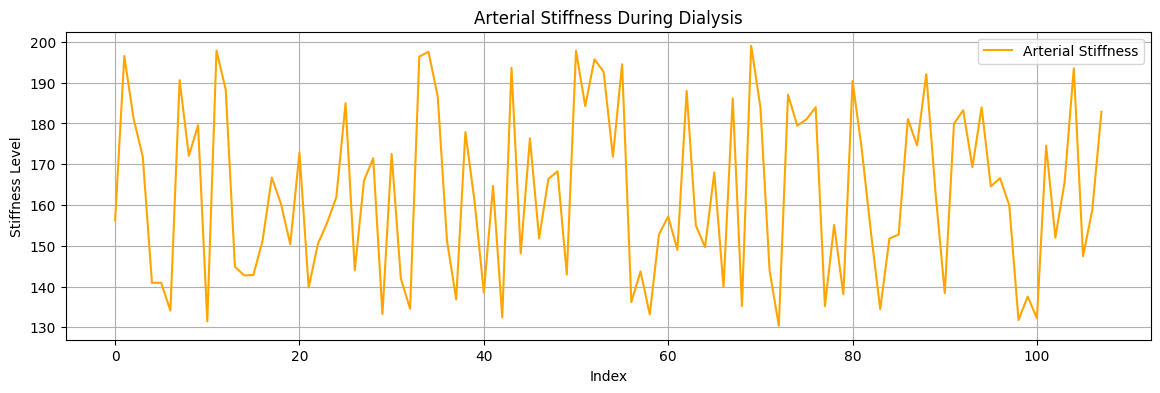

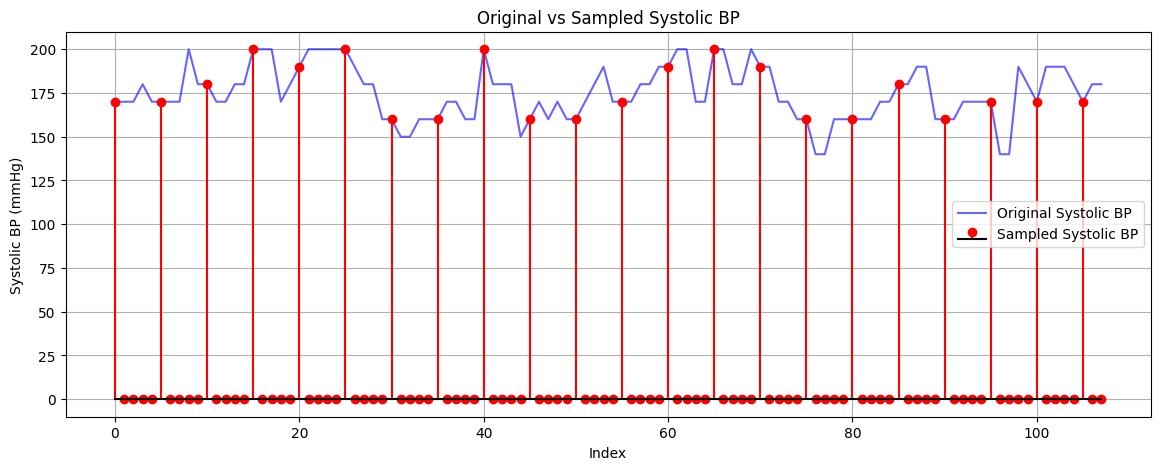

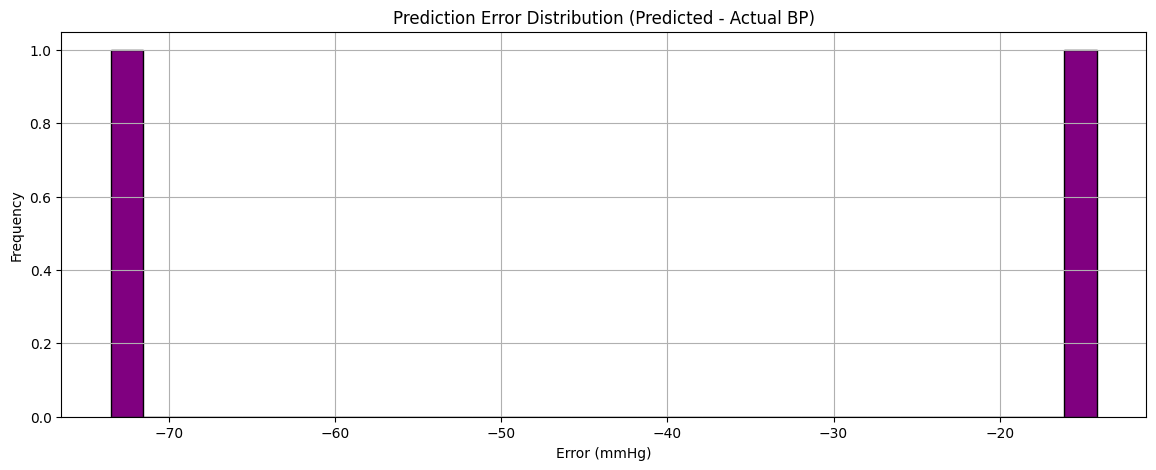

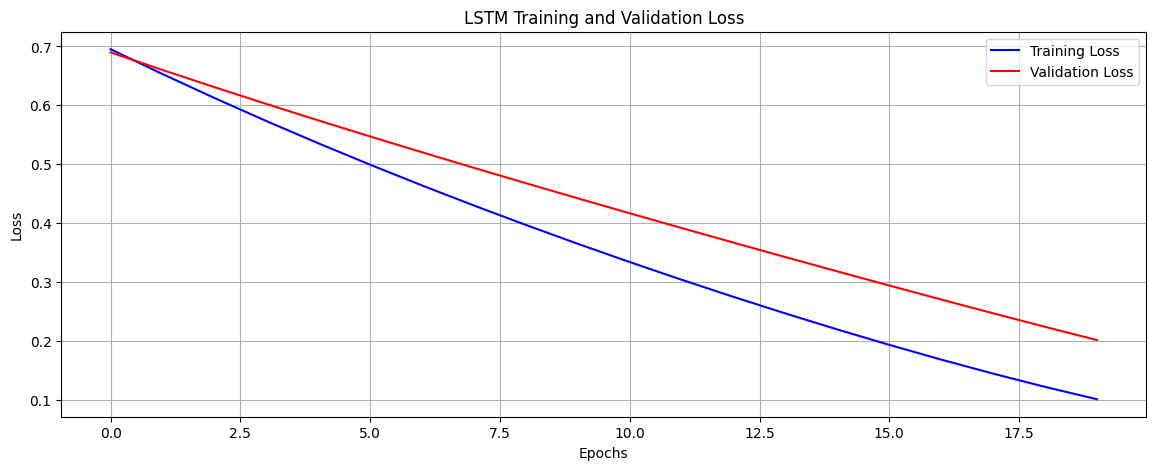

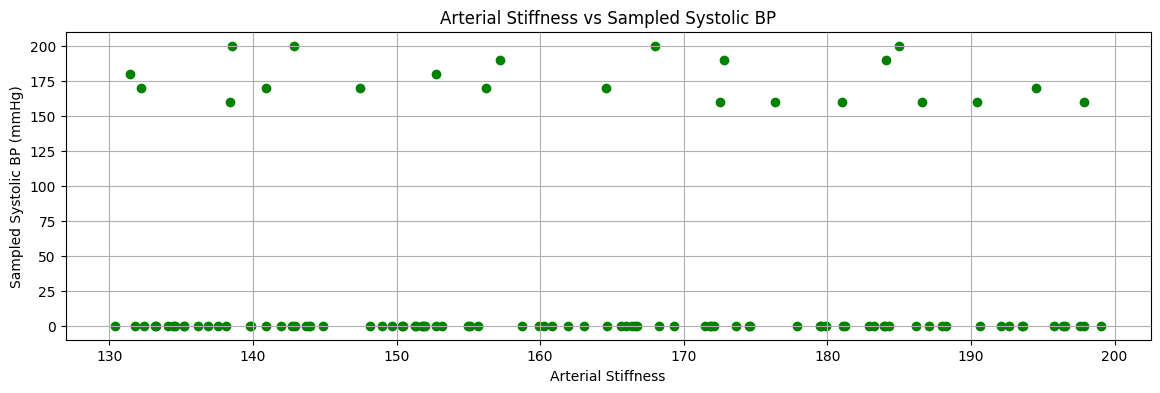

✅ RMSE (Test Set): 52.94 mmHg


In [16]:
# Step 1: Install & import necessary libraries
!pip install -q openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from google.colab import files

# Step 2: Upload file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 3: Load data
df = pd.read_excel(filename)
print("Columns:", df.columns)

# Step 4: Normalize Systolic BP
df['SYSTOLE_NORM'] = df['SYSTOLE'] / 220.0

# Step 5: Generate synthetic arterial stiffness (for demo)
np.random.seed(42)
df['ARTERIAL_STIFFNESS'] = np.random.uniform(130, 200, size=len(df))

# Normalize stiffness
scaler_stiff = MinMaxScaler()
df['STIFF_NORM'] = scaler_stiff.fit_transform(df[['ARTERIAL_STIFFNESS']])

# Step 6: ECG-style impulse sampling
impulse_interval = 5
df['Impulse'] = 0
df.loc[::impulse_interval, 'Impulse'] = 1
df['Sampled'] = df['SYSTOLE_NORM'] * df['Impulse']

# Step 7: Prepare LSTM sequences
window_size = 5
X, Y, keys = [], [], []

for date, group in df.groupby('DATE'):
    if len(group) <= window_size:
        continue
    sampled = group['Sampled'].values
    label = group['SYSTOLE_NORM'].values
    stiff = group['STIFF_NORM'].values
    for i in range(len(sampled) - window_size):
        seq = np.stack([sampled[i:i + window_size], stiff[i:i + window_size]], axis=-1)
        X.append(seq)
        Y.append(label[i + window_size])
        keys.append(date)

# ✅ Convert to NumPy arrays
X = np.array(X)
Y = np.array(Y)
keys = np.array(keys)

print(f"✅ Total sequences created: {len(X)} from {len(df['DATE'].unique())} unique dates")


# Step 8: Split data by date
unique_dates = sorted(np.unique(keys))
reserved_test_dates = unique_dates[-10:]
train_dates = unique_dates[:-10]

# Boolean masks for selection
train_mask = np.isin(keys, train_dates)
reserved_mask = np.isin(keys, reserved_test_dates)

# Prepare main training pool
X_train_all = X[train_mask]
Y_train_all = Y[train_mask]

# Split train_dates pool into train/test/val (70/20/10)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_train_all, Y_train_all, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=2/3, random_state=42)

# Reserved final test set (from last 10 dates)
X_final_test = X[reserved_mask]
Y_final_test = Y[reserved_mask]

# Step 9: Build & train LSTM
model = Sequential([
    Input(shape=(window_size, 2)),
    LSTM(64),
    Dense(1)
])
model.compile(optimizer=Adam(0.001), loss='mse')
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=16)

# Step 10: Predict and visualize
Y_pred = model.predict(X_test).flatten()
Y_pred_actual = Y_pred * 220
Y_test_actual = Y_test * 220

# === Plot 1: Actual vs Predicted BP ===
plt.figure(figsize=(14, 5))
plt.plot(Y_test_actual, label='Actual BP', color='blue')
plt.plot(Y_pred_actual, label='Predicted BP', color='red', linestyle='--')
plt.title('Predicted vs Actual Systolic BP')
plt.xlabel('Sample Index')
plt.ylabel('Systolic BP (mmHg)')
plt.legend()
plt.grid(True)
plt.show()

# === Plot 2: ECG-style sampled signal ===
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['SYSTOLE'], label='Original BP', alpha=0.4, color='gray')
plt.stem(df.index, df['Sampled'] * 220, linefmt='r-', markerfmt='ro', basefmt='k-', label='ECG-style Sampled')
plt.title('ECG-Style Sampled Systolic BP Signal')
plt.xlabel('Index')
plt.ylabel('Systolic BP')
plt.legend()
plt.grid(True)
plt.show()

# === Plot 3: Arterial stiffness correlation ===
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['ARTERIAL_STIFFNESS'], label='Arterial Stiffness', color='orange')
plt.title('Arterial Stiffness During Dialysis')
plt.xlabel('Index')
plt.ylabel('Stiffness Level')
plt.legend()
plt.grid(True)
plt.show()

# === Plot 4: Original vs Sampled Systolic BP ===
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['SYSTOLE'], label='Original Systolic BP', alpha=0.6, color='blue')
plt.stem(df.index, df['Sampled'] * 220, label='Sampled Systolic BP', linefmt='r-', markerfmt='ro', basefmt='k-')

plt.title('Original vs Sampled Systolic BP')
plt.xlabel('Index')
plt.ylabel('Systolic BP (mmHg)')
plt.legend()
plt.grid(True)
plt.show()

# === Plot 5: Prediction Error Distribution ===
errors = Y_pred_actual - Y_test_actual
plt.figure(figsize=(14, 5))
plt.hist(errors, bins=30, color='purple', edgecolor='black')
plt.title('Prediction Error Distribution (Predicted - Actual BP)')
plt.xlabel('Error (mmHg)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# === Plot 6: LSTM Training Loss ===
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# === Plot 7: Arterial Stiffness vs Sampled BP ===
plt.figure(figsize=(14, 4))
plt.scatter(df['ARTERIAL_STIFFNESS'], df['Sampled'] * 220, color='green')
plt.title('Arterial Stiffness vs Sampled Systolic BP')
plt.xlabel('Arterial Stiffness')
plt.ylabel('Sampled Systolic BP (mmHg)')
plt.grid(True)
plt.show()


# === Report ===
rmse = np.sqrt(mean_squared_error(Y_test_actual, Y_pred_actual))
print(f"✅ RMSE (Test Set): {rmse:.2f} mmHg")
